In [224]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import uns
import pandas as pd
folder = '/home/chrisv/code/fcn_train_log'
filepattern = 'predictions_*'
files = glob.glob(os.path.join(folder, filepattern))

In [2]:
from skimage.morphology import convex_hull_image

In [142]:
tr = pd.read_msgpack('trainvalidate.bin')


In [225]:
def ndice(pred_batch,label_batch,sh=(416,576)):
      n_batch = pred_batch.shape[0]
      preds = pred_batch.reshape([n_batch,sh[0],sh[1]])
      labels = label_batch.reshape([n_batch,sh[0],sh[1]])
      denoms = np.sum(preds,axis=(1,2)) + np.sum(labels,axis=(1,2))
      cap = np.logical_and(preds, labels)
      numerators = 2*np.sum(cap, axis=(1,2))
      zero_denoms = np.where(denoms ==0)
      nonzero_denoms = np.where (denoms !=0)
      result = np.empty(denoms.shape)
      result[zero_denoms] = 1
      result[nonzero_denoms] = np.divide(numerators[nonzero_denoms],denoms[nonzero_denoms])
      return result

In [226]:
idxpred = 0
idxmask = 1

for f in files:
    print(f, ": ", np.load(f).shape)

/home/chrisv/code/fcn_train_log/predictions_chunk_1.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_11.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_10.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_7.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_2.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_12.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_6.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_8.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_4.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_9.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_5.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_0.npy :  (2, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predi

In [227]:
strange_data = np.concatenate([np.load(f) for f in files], axis=0)

In [228]:
data = np.reshape(np.transpose(strange_data,(0,2,1,3,4)), (-1,2,416,576))

In [229]:
# Pixel count cutoff
# convex hull or shape normalization
# softmax output (not predictions)


0.96004617

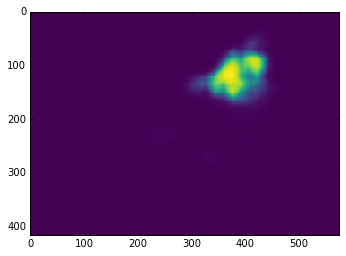

In [230]:
plt.imshow(data[5,0,:,:], cmap=plt.cm.viridis, interpolation='nearest')
data[5,0,:,:].max()

231044

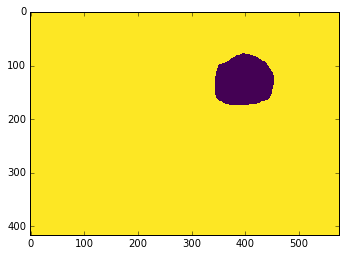

In [231]:
plt.imshow(data[5,1,:,:], cmap=plt.cm.viridis, interpolation='nearest')
np.count_nonzero(data[5,1,:,:])

In [238]:
cutoff = np.linspace(0,1,num=20)

score = [np.mean(ndice(data[:,idxpred,:,:]>c, 1-data[:,idxmask,:,:])) for c in cutoff]


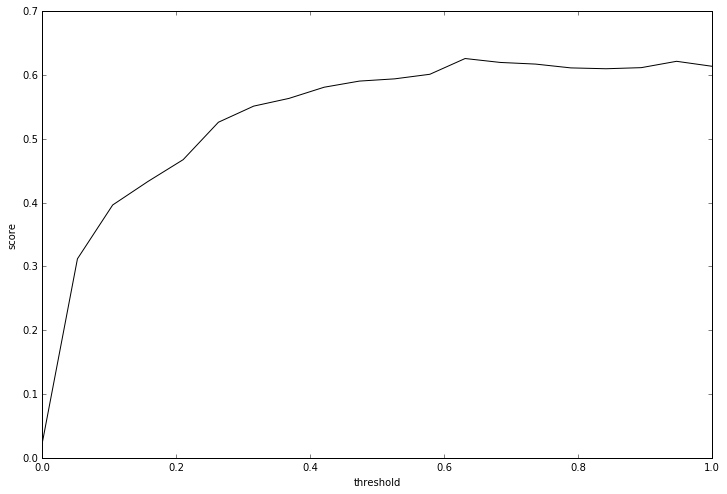

In [240]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(cutoff, score, '-k')
ax.set_ylabel('score')
ax.set_xlabel('threshold')

Why so many zero scores?

In [264]:
cutoff=0.6

indices = np.argwhere(score == 0)

maskpix = np.array([np.sum(m) for m in 1-data[:,idxmask,:,:]] )
predpix = np.array([np.sum(p) for p in data[:,idxpred,:,:]>0.5])


score = ndice(data[:,idxpred,:,:]>cutoff, 1-data[:,idxmask,:,:])
print('Raw score: {}'.format(np.mean(score)))
subset = data[predpix<500,idxpred,:,:]>cutoff
score[predpix<500] = ndice(subset, np.zeros_like(subset))

print('Filter small masks: {}'.format(np.mean(score)))

Raw score: 0.6148922829984751
Filter small masks: 0.7427173484647681


In [219]:
indices = np.argwhere(np.logical_and(score>0.6, score<1)).flatten()
print(indices[:10])
batch = uns.batch(tr[tr['validate']].iloc[indices[:10]])

[ 17  25  26  40  61  65  90  95 110 115]


In [197]:
tr[tr['validate']]

,centcol,centrow,contH,contW,contour,contxmax,contxmin,contymax,contymin,hasmask,...,svdx1,svdy0,svdy1,unitcontour,sv0,sv1,sv2,sv3,train,validate
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
41,0.608334,0.234772,0.165513,0.158625,"[[181.001960784, 179.11349862, 175.620182817, ...",0.312072,0.153448,0.684486,0.518973,True,...,0.198914,0.294061,0.195992,"[[0.0773002158529, 0.0740442466046, 0.06802128...",-0.462806,0.167542,-0.004756,0.068103,False,True
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
49,0.687635,0.226115,0.189676,0.163799,"[[175.001960784, 175.001960784, 175.001960784,...",0.301728,0.137929,0.784499,0.594822,True,...,0.375349,0.420114,0.039170,"[[0.0756122193837, 0.0756122193837, 0.07561221...",-0.520923,-0.150497,0.142905,0.061070,False,True
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
56,0.525207,0.205669,0.112078,0.150055,"[[162.001960784, 162.002231227, 160.175111361,...",0.279314,0.129259,0.584486,0.472409,True,...,0.011520,0.015190,0.246512,"[[0.0736452229359, 0.0736456892166, 0.07049548...",-0.400658,-0.058990,0.015420,0.043366,False,True
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


In [220]:
def plot_pred_mask(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))    
    ax.imshow(data[idx,idxpred,:,:], alpha=0.5, cmap=plt.cm.plasma)
    ax.imshow(data[idx,idxmask,:,:], alpha=0.5, cmap=plt.cm.gray)
    ax.set_title(score[idx])
    return ax

In [221]:
indices = np.argwhere(np.logical_and(score>0.6, score<1)).flatten()[:10]
indices

array([ 17,  25,  26,  40,  61,  65,  90,  95, 110, 115])

In [222]:
for row in tr[tr['validate']].iloc[:10].iterrows():
    print(row[1][['subject','img','hasmask']])

subject        1
img           38
hasmask    False
Name: 37, dtype: object
subject        1
img           40
hasmask    False
Name: 39, dtype: object
subject        1
img           41
hasmask    False
Name: 40, dtype: object
subject       1
img          42
hasmask    True
Name: 41, dtype: object
subject        1
img           46
hasmask    False
Name: 45, dtype: object
subject       1
img          50
hasmask    True
Name: 49, dtype: object
subject        1
img           55
hasmask    False
Name: 54, dtype: object
subject       1
img          57
hasmask    True
Name: 56, dtype: object
subject        1
img           68
hasmask    False
Name: 67, dtype: object
subject        1
img           73
hasmask    False
Name: 72, dtype: object


>>> training[training['validate']][['subject','img']]
      subject  img
37          1   38
39          1   40
40          1   41
41          1   42
45          1   46
49          1   50
54          1   55
56          1   57
67          1   68
72          1   73
74          1   75
80          1   81
81          1   82
84          1   85
87          1   88
93          1   94
95          1   96
99          1  100
101         1  102
110         1  111
120         2    1
130         2   11
136         2   17
139         2   20
141         2   22
149         2   30
153         2   34
159         2   40
160         2   41
164         2   45
...       ...  ...
5468       46   74
5479       46   85
5480       46   86
5482       46   88
5488       46   94
5493       46   99
5496       46  102
5497       46  103
5498       46  104
5518       47    4
5525       47   11
5532       47   18
5535       47   21
5537       47   23
5544       47   30
5546       47   32
5549       47   35
5555       47   41
5556       47   42
5558       47   44
5561       47   47
5582       47   68
5586       47   72
5589       47   75
5596       47   82
5597       47   83
5603       47   89
5606       47   92
5632       47  118
5634       47  120

[1127 rows x 2 columns]

Set any predictions with less than X pixels to zero

(array([ 68.,   5.,   4.,   3.,   3.,   5.,   5.,   5.,   6.,   5.,   4.,
          4.,   1.,   5.,   4.,   3.,   3.,   3.,   1.,   3.,   4.,   3.,
          1.,   5.,   3.,   6.,   2.,   2.,   4.,   2.,   2.,   3.,   1.,
          2.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   3.,   0.,   1.,
          1.,   2.,   0.,   0.,   1.,   1.]),
 array([     0. ,    203.6,    407.2,    610.8,    814.4,   1018. ,
          1221.6,   1425.2,   1628.8,   1832.4,   2036. ,   2239.6,
          2443.2,   2646.8,   2850.4,   3054. ,   3257.6,   3461.2,
          3664.8,   3868.4,   4072. ,   4275.6,   4479.2,   4682.8,
          4886.4,   5090. ,   5293.6,   5497.2,   5700.8,   5904.4,
          6108. ,   6311.6,   6515.2,   6718.8,   6922.4,   7126. ,
          7329.6,   7533.2,   7736.8,   7940.4,   8144. ,   8347.6,
          8551.2,   8754.8,   8958.4,   9162. ,   9365.6,   9569.2,
          9772.8,   9976.4,  10180. ]),
 <a list of 50 Patch objects>)

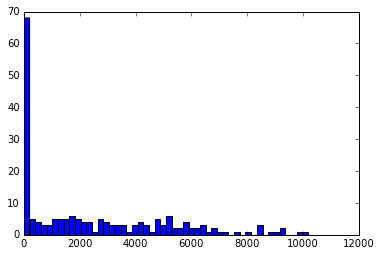

In [257]:


plt.hist(predpix[maskpix>0.1], bins=50)

0 : 17 subject        1
img          100
hasmask    False
Name: 99, dtype: object


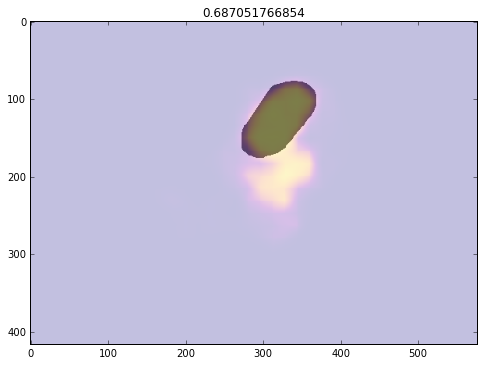

1 : 25 subject        2
img           30
hasmask    False
Name: 149, dtype: object


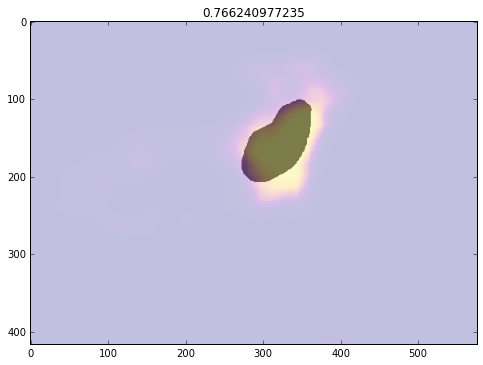

2 : 26 subject        2
img           34
hasmask    False
Name: 153, dtype: object


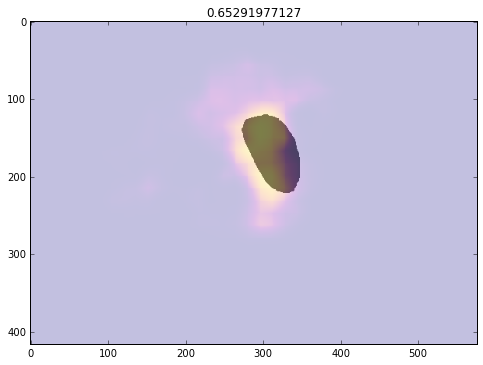

3 : 40 subject        2
img           96
hasmask    False
Name: 215, dtype: object


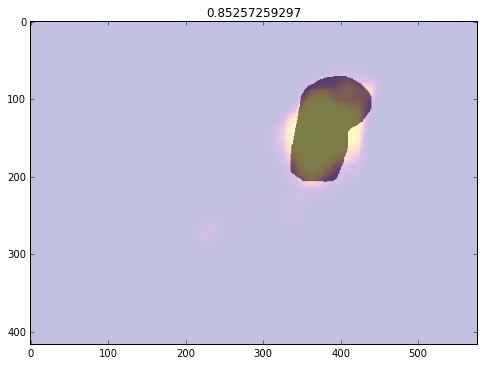

4 : 61 subject       3
img          56
hasmask    True
Name: 295, dtype: object


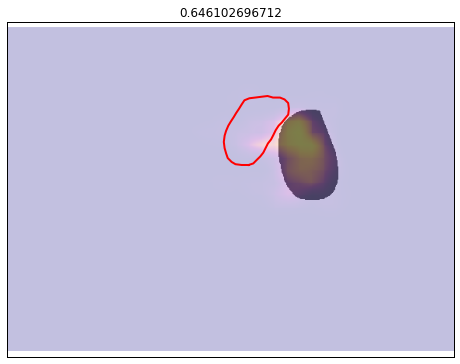

5 : 65 subject       3
img          64
hasmask    True
Name: 303, dtype: object


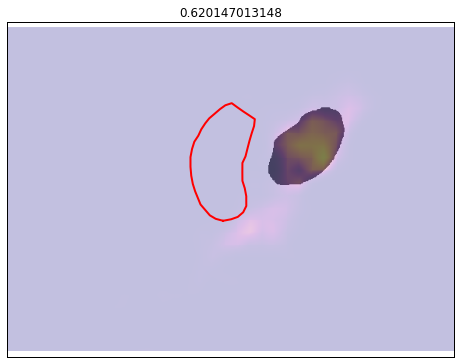

6 : 90 subject        4
img           60
hasmask    False
Name: 418, dtype: object


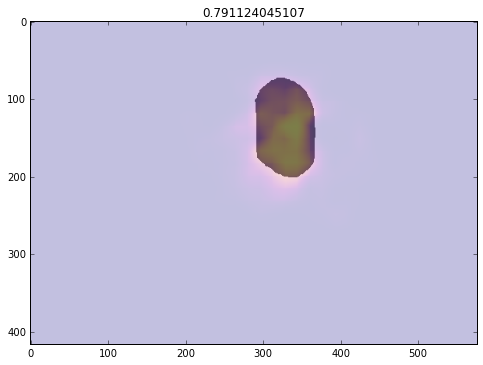

7 : 95 subject        4
img           79
hasmask    False
Name: 437, dtype: object


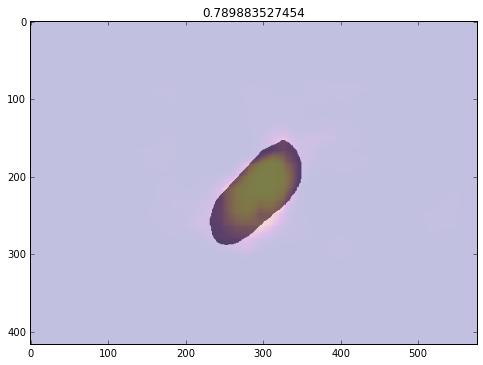

8 : 110 subject        5
img           21
hasmask    False
Name: 499, dtype: object


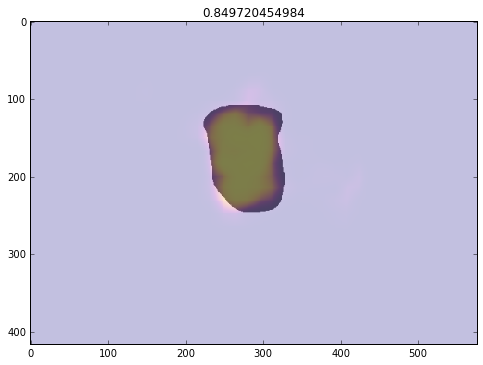

9 : 115 subject        5
img           34
hasmask    False
Name: 512, dtype: object


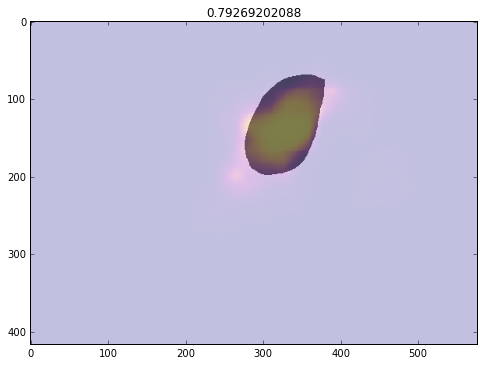

In [223]:
subset = tr[tr['validate']].iloc[indices]
batch = uns.batch(subset)

for i,j in enumerate(indices[:20]):
    print(i,':',j, subset.iloc[i][['subject','img','hasmask']])
    ax = plot_pred_mask(j)
    batch[i].mask.plot_contour(ax=ax, lw=2.0, c='r')
    plt.show()
    

What do the masks in the bottleneck files look like?

In [171]:
indices = [6,7]

1_55.btl


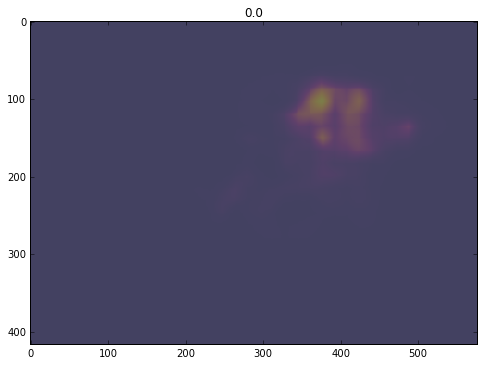

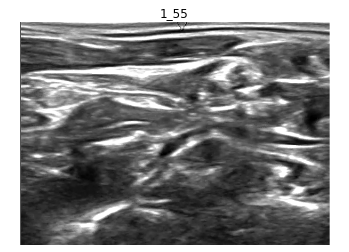

In [172]:
batch = uns.batch(tr[tr['validate']].iloc[indices])

imgpair = batch.pop(0)
print(imgpair.bottlefile)
i = indices.pop(0)
plot_pred_mask(i)
imgpair.plot()
record = np.fromfile('../bottleneck_files/' + imgpair.bottlefile, dtype=np.float32)

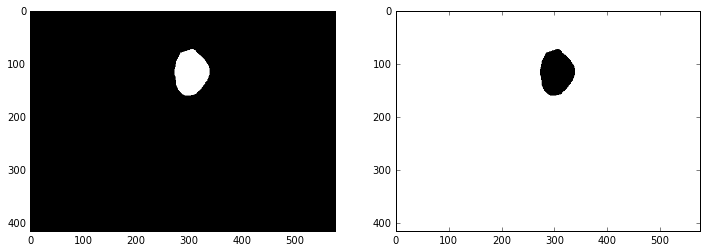

In [135]:
fc6dim = 13, 18, 4096
pooldim = 26, 36, 512
maskdim = 416, 576, 2 

Nfc6 = np.prod(fc6dim)
Npool = np.prod(pooldim)
Nmask = np.prod(maskdim)
#print(record.shape, Nfc6 + Npool + Nmask)

fc6 = record[:Nfc6].reshape(fc6dim)
pool = record[Nfc6:Nfc6+Npool].reshape(pooldim)
mask = np.reshape(record[Nfc6+Npool:], maskdim)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(mask[:,:,0], cmap=plt.cm.gray)
ax[1].imshow(mask[:,:,1], cmap=plt.cm.gray)

0


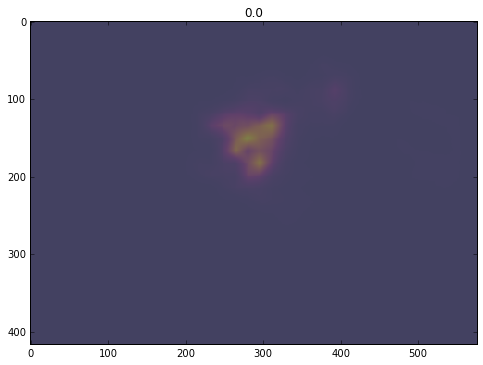

In [136]:
j = np.argmax(np.sum(np.logical_and(mask[:,:,0]>0, data[:,idxmask,:,:]), axis=(2,1)))

plot_pred_mask(j)
print(j)